# Final model full stack

This notebook contains the full stack of the final model, including:
- Read dataset
- Preprocess images and labels
- Prepare the dataset
- Construction of the model
- Training models for crossvalidation
- Constructing the final model (ensamble)
- Predicting test images and writing the results

This notebook was developed using the following software versions:
- Ubuntu 20.04
- python 3.8.5
- tensorflow 2.3.1
- pandas 1.0.5
- numpy 1.17.4
- matplotlib 3.1.2

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as kls
import matplotlib.pyplot as plt

### Paths to the data
Define the paths containing the train data

In [2]:
data_dir = 'trainset/images_train/'
labels_path = data_dir + 'data.csv'

### Load and process labels
Load labels and process them to extract the accent type and the vowel. Also, encode the labels in a numerical format suitable for training.

In [3]:
# load labels
labels_data = pd.read_csv(labels_path)
labels_data['values'] = pd.Categorical(labels_data['values'])

# add vowels labels
labels_data['vowels'] = list(map(lambda s: s[0], labels_data['values']))
labels_data['vowels'] = pd.Categorical(labels_data['vowels'])

# add accent labels
accent_dict = {' ': ['aa', 'ee', 'ii', 'oo', 'uu'],
               '`': ['aà', 'eè', 'iì', 'oò', 'uù'],
               '´': ['aá', 'eé', 'ií', 'oó', 'uú'],
               '¨': ['aä', 'eë', 'iï', 'oö', 'uü'],
               '^': ['aâ', 'eê', 'iî', 'oô', 'uû'],
               '¯': ['aā', 'eē', 'iı̄', 'oō', 'uū']}
def which_accent(s:str):
    for k in accent_dict:
        if s in accent_dict[k]:
            return k
    return None

labels_data['accents'] = list(map(which_accent, labels_data['values']))
labels_data['accents'] = pd.Categorical(labels_data['accents'])

# add the labels in numeric format
vowel2num = {'a': 0, 'e': 1, 'i':2, 'o': 3, 'u': 4}
accent2num = {' ': 0, '`': 1, '´': 2, '¨': 3, '^': 4, '¯': 5}
value2num = {'aa':  0, 'aà':  1, 'aá':  2, 'aä':  3, 'aâ':  4, 'aā':  5,
             'ee':  6, 'eè':  7, 'eé':  8, 'eë':  9, 'eê': 10, 'eē': 11,
             'ii': 12, 'iì': 13, 'ií': 14, 'iï': 15, 'iî': 16, 'iı̄': 17,
             'oo': 18, 'oò': 19, 'oó': 20, 'oö': 21, 'oô': 22, 'oō': 23,
             'uu': 24, 'uù': 25, 'uú': 26, 'uü': 27, 'uû': 28, 'uū': 29}

labels_data['values_num'] = labels_data['values'].map(lambda x: value2num[x])
labels_data['vowels_num'] = labels_data['vowels'].map(lambda x: vowel2num[x])
labels_data['accents_num'] = labels_data['accents'].map(lambda x: accent2num[x])


print('Processed labels:')
labels_data.head(10)

Processed labels:


,id,values,vowels,accents,values_num,vowels_num,accents_num
0,0,oō,o,¯,23,3,5
1,1,oö,o,¨,21,3,3
2,2,eê,e,^,10,1,4
3,3,oó,o,´,20,3,2
4,4,ii,i,,12,2,0
5,5,eë,e,¨,9,1,3
6,6,uū,u,¯,29,4,5
7,7,ii,i,,12,2,0
8,8,eè,e,`,7,1,1
9,9,oò,o,`,19,3,1


### Generate a TF dataset with preprocessing

Example images loaded and preprocessed:


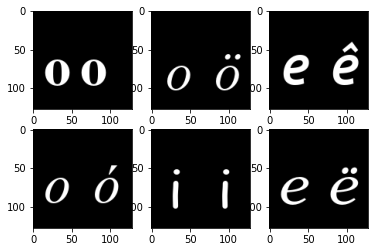

In [4]:
# dataset for labels of vowels and accents
ds_labels = tf.data.Dataset.from_tensor_slices({'vowels': labels_data['vowels_num'],
                                                'accents': labels_data['accents_num']})

# dataset for images
ds_images = [data_dir + f'train_image_{i:05d}.png' for i in range(2000)]
ds_images = tf.data.Dataset.from_tensor_slices(ds_images)
def image_preprocess(image): # image loading pipeline, including preprocessing
    image = tf.io.read_file(image)
    image = tf.io.decode_png(image, channels=1) # read in black and white
    image = tf.image.convert_image_dtype(image, tf.float32) # pixel values between 0 and 1
    image = 1 - image # invert colors so background has value 0
    image = image / tf.reduce_max(image) # normalize to [0, 1]
    image.set_shape([128, 128, 1]) # set shape because it is not automatically infered at compile time. Assume 128x128.
    return image
ds_images = ds_images.map(image_preprocess)

# plot some example image
print('Example images loaded and preprocessed:')
fig, axes = plt.subplots(2,3)
for ax, im in zip(axes.flat, ds_images.take(6)):
    im = im.numpy()
    ax.imshow(im[...,0], vmin=0, vmax=1, cmap='gray')

### Assamble dataset and split it
Assable the dataset (images and labels) and make the splits for 5 fold cross validation.

In [5]:
ds_all = tf.data.Dataset.zip((ds_images, ds_labels))
# shuffle, seed 42 for repeatability
ds_all = ds_all.shuffle(buffer_size=2000, seed=42, reshuffle_each_iteration=False)

#cross validation splits:
n_folds = 5
ds_vals = [ds_all.shard(n_folds, i) for i in range(n_folds)]
ds_trains = []
for i in range(n_folds):
    dsl = [ds_all.shard(n_folds, j) for j in range(n_folds) if j!=i]
    ds = dsl[0]
    for j in range(1, n_folds-1):
        ds = ds.concatenate(dsl[j])
    ds_trains.append(ds.shuffle(2000))

### Construction of the models

In [6]:
class MyModel(keras.Model):
    def __init__(self):
        input_shape = (128, 128, 1)
        output_shape = (30,)
        
        self.build_model(input_shape, output_shape)

    def build_model(self, input_shape, output_shape):
        # Input
        input_layer = tf.keras.Input(shape=input_shape, name='input_layer')
        x = input_layer
        
        # model
        x = kls.Conv2D(32, 3, padding='same')(x)
        x = kls.BatchNormalization()(x)
        x = kls.MaxPool2D()(x)
        x = kls.Activation('relu')(x)

        x = kls.Conv2D(64, 3, padding='same')(x)
        x = kls.BatchNormalization()(x)
        x = kls.MaxPool2D()(x)
        x = kls.Activation('relu')(x)

        x = kls.Conv2D(128, 3, padding='same')(x)
        x = kls.BatchNormalization()(x)
        x = kls.MaxPool2D()(x)
        x = kls.Activation('relu')(x)

        x = kls.Conv2D(256, 3, padding='same')(x)
        x = kls.BatchNormalization()(x)
        x = kls.MaxPool2D()(x)
        x = kls.Activation('relu')(x)

        x = kls.Conv2D(512, 3, padding='same')(x)
        x = kls.BatchNormalization()(x)
        x = kls.Activation('relu')(x)
        
        x = kls.GlobalMaxPool2D()(x)
        x = kls.Dense(4096, activation='relu')(x)
        x1 = kls.Dense(5, activation='softmax')(x) # output for vowels
        x2 = kls.Dense(6, activation='softmax')(x) # output for accents
        
        # create the model
        super().__init__(inputs=input_layer, outputs={'vowels':x1, 'accents':x2})
        
        
        
models = [MyModel() for i in range(n_folds)]

print(models[0].summary())

Model: "my_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

### Compile the models
The loss is the sum of the crossentropy of the two heads.

In [7]:
# loss function:
model_loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False, name='values_xent')

for model in models:
    model.compile(optimizer='adam', loss=model_loss, metrics=['accuracy'])

### Training and evaluation of the models

In [12]:
metrics = []
for model, ds_train, ds_val in zip(models, ds_trains, ds_vals):
    model.fit(ds_train.batch(32), epochs=32, validation_data=ds_val.batch(16))
    metrics.append(model.evaluate(ds_val.batch(16)))

Epoch 1/32
50/50 [==============================] - 2s 41ms/step - loss: 5.6082 - dense_2_loss: 3.2862 - dense_1_loss: 2.3220 - dense_2_accuracy: 0.1875 - dense_1_accuracy: 0.3675 - val_loss: 3.9426 - val_dense_2_loss: 1.8065 - val_dense_1_loss: 2.1361 - val_dense_2_accuracy: 0.1775 - val_dense_1_accuracy: 0.1800
Epoch 2/32
50/50 [==============================] - 2s 36ms/step - loss: 2.3865 - dense_2_loss: 1.6591 - dense_1_loss: 0.7274 - dense_2_accuracy: 0.3219 - dense_1_accuracy: 0.7337 - val_loss: 5.4534 - val_dense_2_loss: 1.9487 - val_dense_1_loss: 3.5046 - val_dense_2_accuracy: 0.1775 - val_dense_1_accuracy: 0.1800
Epoch 3/32
50/50 [==============================] - 2s 36ms/step - loss: 1.1125 - dense_2_loss: 0.9292 - dense_1_loss: 0.1833 - dense_2_accuracy: 0.6712 - dense_1_accuracy: 0.9463 - val_loss: 7.6395 - val_dense_2_loss: 2.8339 - val_dense_1_loss: 4.8056 - val_dense_2_accuracy: 0.1775 - val_dense_1_accuracy: 0.1800
Epoch 4/32
50/50 [==============================] - 2s 

Epoch 19/32
50/50 [==============================] - 2s 37ms/step - loss: 1.4683e-04 - dense_5_loss: 7.8049e-05 - dense_4_loss: 6.8778e-05 - dense_5_accuracy: 1.0000 - dense_4_accuracy: 1.0000 - val_loss: 0.0089 - val_dense_5_loss: 0.0054 - val_dense_4_loss: 0.0034 - val_dense_5_accuracy: 0.9975 - val_dense_4_accuracy: 0.9975
Epoch 20/32
50/50 [==============================] - 2s 36ms/step - loss: 1.5284e-04 - dense_5_loss: 7.4992e-05 - dense_4_loss: 7.7847e-05 - dense_5_accuracy: 1.0000 - dense_4_accuracy: 1.0000 - val_loss: 0.0049 - val_dense_5_loss: 0.0036 - val_dense_4_loss: 0.0012 - val_dense_5_accuracy: 0.9975 - val_dense_4_accuracy: 1.0000
Epoch 21/32
50/50 [==============================] - 2s 36ms/step - loss: 1.1591e-04 - dense_5_loss: 6.7159e-05 - dense_4_loss: 4.8748e-05 - dense_5_accuracy: 1.0000 - dense_4_accuracy: 1.0000 - val_loss: 0.0062 - val_dense_5_loss: 0.0042 - val_dense_4_loss: 0.0020 - val_dense_5_accuracy: 0.9975 - val_dense_4_accuracy: 1.0000
Epoch 22/32
50/5

Epoch 12/32
50/50 [==============================] - 2s 36ms/step - loss: 4.9038e-04 - dense_8_loss: 3.2835e-04 - dense_7_loss: 1.6203e-04 - dense_8_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - val_loss: 0.4263 - val_dense_8_loss: 0.3567 - val_dense_7_loss: 0.0695 - val_dense_8_accuracy: 0.8800 - val_dense_7_accuracy: 0.9825
Epoch 13/32
50/50 [==============================] - 2s 36ms/step - loss: 4.3904e-04 - dense_8_loss: 2.5768e-04 - dense_7_loss: 1.8136e-04 - dense_8_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - val_loss: 0.1060 - val_dense_8_loss: 0.0914 - val_dense_7_loss: 0.0147 - val_dense_8_accuracy: 0.9675 - val_dense_7_accuracy: 0.9900
Epoch 14/32
50/50 [==============================] - 2s 36ms/step - loss: 3.5126e-04 - dense_8_loss: 2.2906e-04 - dense_7_loss: 1.2219e-04 - dense_8_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - val_loss: 0.0485 - val_dense_8_loss: 0.0395 - val_dense_7_loss: 0.0090 - val_dense_8_accuracy: 0.9875 - val_dense_7_accuracy: 0.9975
Epoch 15/32
50/5

50/50 [==============================] - 2s 36ms/step - loss: 7.9291e-05 - dense_11_loss: 5.5050e-05 - dense_10_loss: 2.4241e-05 - dense_11_accuracy: 1.0000 - dense_10_accuracy: 1.0000 - val_loss: 0.0321 - val_dense_11_loss: 0.0320 - val_dense_10_loss: 7.1514e-05 - val_dense_11_accuracy: 0.9900 - val_dense_10_accuracy: 1.0000
Epoch 29/32
50/50 [==============================] - 2s 36ms/step - loss: 6.6462e-05 - dense_11_loss: 4.7195e-05 - dense_10_loss: 1.9268e-05 - dense_11_accuracy: 1.0000 - dense_10_accuracy: 1.0000 - val_loss: 0.0333 - val_dense_11_loss: 0.0333 - val_dense_10_loss: 5.9857e-05 - val_dense_11_accuracy: 0.9925 - val_dense_10_accuracy: 1.0000
Epoch 30/32
50/50 [==============================] - 2s 36ms/step - loss: 6.2693e-05 - dense_11_loss: 4.4381e-05 - dense_10_loss: 1.8312e-05 - dense_11_accuracy: 1.0000 - dense_10_accuracy: 1.0000 - val_loss: 0.0316 - val_dense_11_loss: 0.0316 - val_dense_10_loss: 6.3188e-05 - val_dense_11_accuracy: 0.9900 - val_dense_10_accuracy:

### Save the models

In [13]:
# create folder to store the models
if not os.path.isdir('saved_models'):
    os.mkdir('saved_models')
    
# save the models
for i in range(n_folds):
    savepath = f'saved_models/mymodel_fold_{i}'
    if os.path.exists(savepath):
        print(f"It already exists the path '{savepath}'. Exiting without saving...")
        break
    models[i].save(savepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/mymodel_fold_0/assets
INFO:tensorflow:Assets written to: saved_models/mymodel_fold_1/assets
INFO:tensorflow:Assets written to: saved_models/mymodel_fold_2/assets
INFO:tensorflow:Assets written to: saved_models/mymodel_fold_3/assets
INFO:tensorflow:Assets written to: saved_models/mymodel_fold_4/assets


### Model performance

In [53]:
# summarize the merics obtained
losses = []
accuracies = []
for m in metrics:
    losses.append(m[0])
    accuracies.append(m[-2]*m[-1]) # it is a good approximation of the total accuracy
print(f'{losses = }')
print(f'{np.mean(losses) = },\n{np.min(losses) = },\n{np.max(losses) = },\n{np.std(losses, ddof=1) = }')
print()
print(f'{accuracies = }')
print(f'{np.mean(accuracies) = :.4f},\n{np.min(accuracies) = :.4f},\n{np.max(accuracies) = :.4f},\n{np.std(accuracies, ddof=1) = :.5f}')

losses = [0.051303714513778687, 0.0031890524551272392, 0.00799492560327053, 0.03552517294883728, 0.009767034091055393]
np.mean(losses) = 0.021555979922413825,
np.min(losses) = 0.0031890524551272392,
np.max(losses) = 0.051303714513778687,
np.std(losses, ddof=1) = 0.0208584007643071

accuracies = [0.9975, 1.0, 0.9975, 0.9925, 0.9975]
np.mean(accuracies) = 0.9970,
np.min(accuracies) = 0.9925,
np.max(accuracies) = 1.0000,
np.std(accuracies, ddof=1) = 0.00274


### Misclassified images
Show the missclassified images of the first model

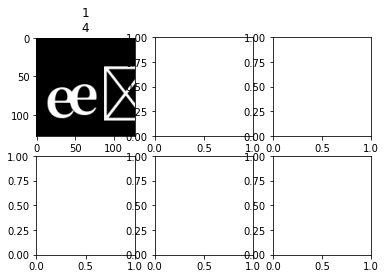

In [32]:
y_ = models[0].predict(ds_vals[0].batch(16))
for k in y_:
    y_[k] = np.argmax(y_[k], axis=1)
y_ = tf.data.Dataset.from_tensor_slices(y_)
missclassified = tf.data.Dataset.zip((ds_vals[0], y_)).filter(lambda x, y_: x[1]['vowels']!=y_['vowels'] or x[1]['accents']!=y_['accents'])
print()

fig, axes = plt.subplots(2, 3)
for ax, im in zip(axes.flat, missclassified.take(500)):
    (im, y), y_ = im
    im = im.numpy()
    ax.imshow(im[...,0], vmin=0, vmax=1, cmap='gray')
    ax.set_title(f"{y_['vowels'].numpy()}\n{y_['accents'].numpy()}")

### Load saved models

In [8]:
models = []
for i in range(n_folds):
    savepath = f'saved_models/mymodel_fold_{i}'
    models.append(keras.models.load_model(savepath))

# Prediction of the test images

### Paths to the data
Define the paths containing the test data

In [9]:
data_dir = 'testset/images_test/'
n_test_images = 5000

### Generate the TF dataset prepared for prediction

Example images loaded and preprocessed:


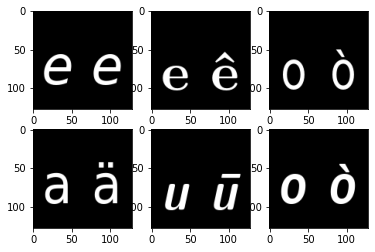

In [10]:
# dataset for images
ds_images = [data_dir + f'test_image_{i:05d}.png' for i in range(n_test_images)]
ds_images = tf.data.Dataset.from_tensor_slices(ds_images)
ds_images = ds_images.map(image_preprocess) # image_preprocess as defined previously

# plot some example image
print('Example images loaded and preprocessed:')
fig, axes = plt.subplots(2,3)
for ax, im in zip(axes.flat, ds_images.take(6)):
    im = im.numpy()
    ax.imshow(im[...,0], vmin=0, vmax=1, cmap='gray')

### Make the predictions
Make the predictions with an ensamble of all the trained models. The ensamble is done to reduce variability as make sure that the real accuracy is close to the accuracy obtained in the crossvalidation.

In [11]:
# Predictions of all models
predictions = []
for model in models:
    predictions.append(model.predict(ds_images.batch(16)))

In [12]:
# Make the ensamble
vowel_predictions = np.stack([y['vowels'] for y in predictions], axis=0)
accent_predictions = np.stack([y['accents'] for y in predictions], axis=0)

vowel_predictions = vowel_predictions.mean(axis=0)
accent_predictions = accent_predictions.mean(axis=0)

vowel_predictions = np.argmax(vowel_predictions, axis=1)
accent_predictions = np.argmax(accent_predictions, axis=1)

### Decode the predictions

In [13]:
encoded_predictions = 6*vowel_predictions + accent_predictions
num2value = {v: k for k, v in value2num.items()}

@np.vectorize
def decode_labels(y):
    return num2value[y]

decoded_predictions = decode_labels(encoded_predictions)

### Save the predictions

In [14]:
df_predictions = pd.DataFrame({'id': np.arange(n_test_images), 'values': decoded_predictions})
df_predictions.to_csv('predictions.csv', index=False)
print(df_predictions)

        id values
0        0     ee
1        1     eê
2        2     oò
3        3     aä
4        4    uū
...    ...    ...
4995  4995    eē
4996  4996     iî
4997  4997     aâ
4998  4998     uu
4999  4999     uù

[5000 rows x 2 columns]
